# First things first
Click on `Runtime` → `Change runtime type`. In the menu that opens, for `Hardware accelerator`, select **`GPU`** and then click `Save`.

In [0]:
from fastai import *
from fastai.vision import *

%matplotlib inline

In [5]:
# you may need to mount the drive if you've changed the runtime
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH = os.path.abspath('/content/drive/My Drive/convnet-demo')

In [0]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv)

In [8]:
display(df.head())
display(df.shape)

,objID,oh_p50
0,1237648704043942146,8.882136
1,1237667292122513532,8.951163
2,1237665441525596194,8.823326
3,1237674289683300721,9.104471
4,1237663716556341422,9.014245


(400, 2)

So here we're viewing the first 5 rows of the data using a Pandas DataFrame, which only contain the SDSS DR14 object identifiers, and the median gas-phase metallicity, $12 + \log({\rm O/H})$, from the MPA-JHU galSpecExtra catalog.

We can also see that there are 400 rows (galaxies) and 2 columns.

# Set up DataBunch object

In [0]:
bs = 64    # batch size
sz = 128   # image size

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='train', suffix='.jpg', cols='objID') # create a fastai ImageList from DataFrame
                .split_by_rand_pct(0.2, seed=1234)                                   # split off 20% of the data for validation
                .label_from_df(cols='oh_p50',  label_cls=FloatList)                  # label the images according to metallicity
      )

In [0]:
# simple data augmentation transforms
tfms = get_transforms(do_flip=True,      # horizontal flips
                      flip_vert=True,    # vertical flips
                      max_warp=0,        # no warping the image
                      p_affine=0.75,     # randomly transform (flips, zooms, etc.) image 75% of the time
                      p_lighting=0,      # never change the lighting of image
                     )

In [0]:
# create DataBunch object 
data = (src.transform(tfms, size=sz)    # allow ImageList to be dynamically transformed and resized on the fly
           .databunch(bs=bs)            # generate a Pytorch/fastai DataBunch object 
           .normalize()                 # data is normalized using mean/variance from first batch
       )

We can now visualize a few examples from the first batch along with their target metallicities.

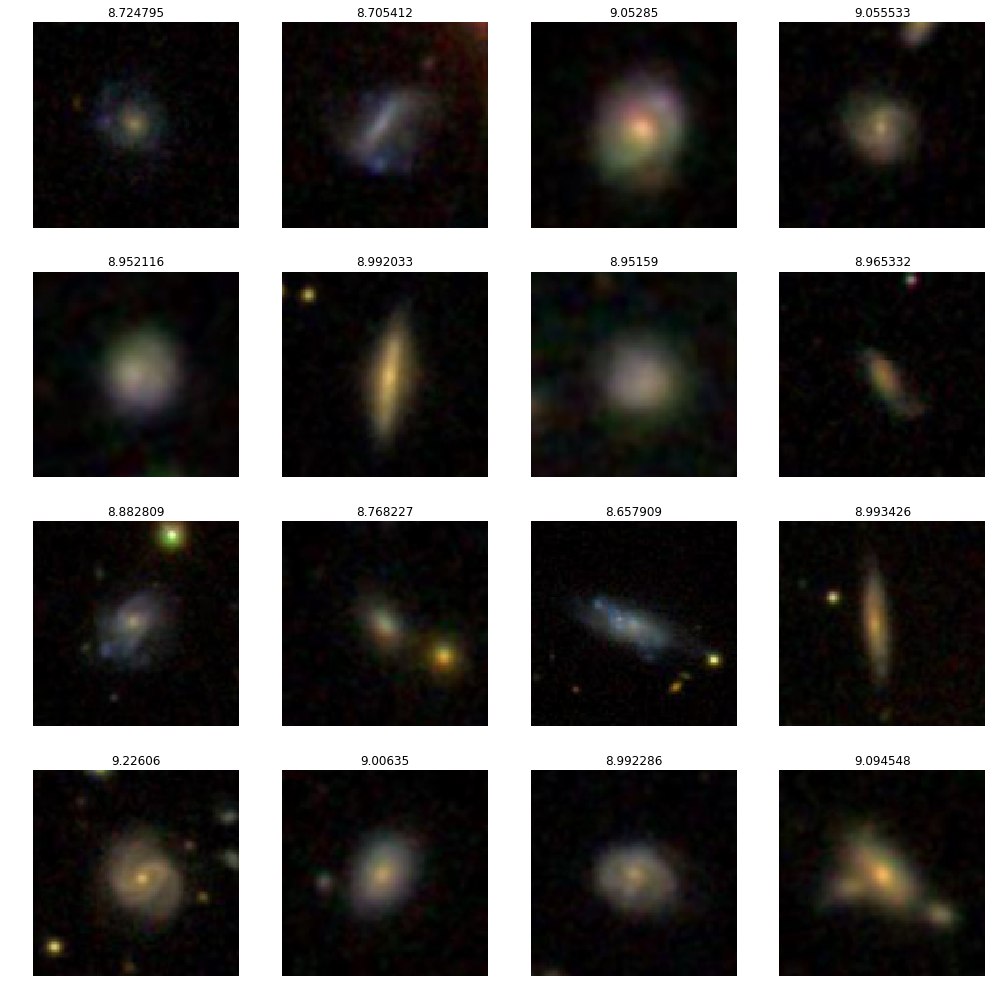

In [15]:
data.show_batch(4, figsize=(14, 14))

# Set up simple convnet

If you want to run the code on the CPU (which is much slower than on the GPU), the uncomment the cell below and run it.

In [0]:
# defaults.device = torch.device('cpu')

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self, pretrained=False):                  # pretrained kw is hardcoded into cnn_learner
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
learn = cnn_learner(data, base_arch=SimpleCNN, pretrained=False, loss_func=root_mean_squared_error)

# Find learning rate and train

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


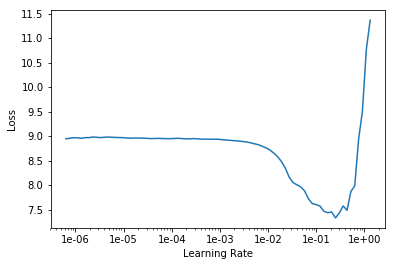

In [22]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

Here we see that the minimum of the plot is at about Learning Rate = 0.3, and that the slope is steepest around 0.03. We will select the latter as our learning rate.

In [0]:
optimal_lr = 3e-2

**Note:** The first epoch that you train will be much slower than the others, because the data and model need to be loaded onto the GPU. Afterwards it accesses the cache and is considerably faster.

In [35]:
learn.fit(5, optimal_lr)

epoch,train_loss,valid_loss,time
0,6.911026,6.519549,00:01
1,4.914294,0.552471,00:01
2,3.938662,0.602655,00:01
3,3.327978,1.740731,00:01
4,2.918574,0.626571,00:01


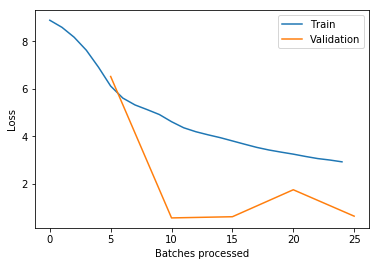

In [36]:
learn.recorder.plot_losses()

At this point the training losses are still quickly dropping. Validation losses are noisy, but during validation, dropout is turned off, so that's why the validation losses are much lower than training losses. Based on this, we are severely underfitting our data. 

We can search again to see if the optimal learning rate has changed (or simply continue with the original one).

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


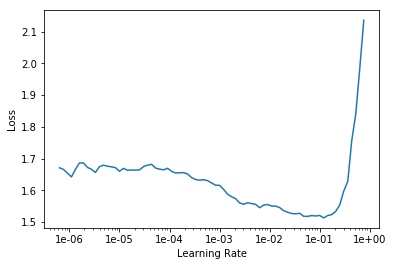

In [31]:
learn.lr_find()
learn.recorder.plot()

At this point I tried dropping the learning rate by a half order of magnitude, but it didn't train as quickly, so I instead kept it the same as before! Note that I often run empirical tests to determine the best way forward.

In [37]:
optimal_lr = 3e-2
learn.fit(10, optimal_lr)

epoch,train_loss,valid_loss,time
0,1.425236,0.476530,00:01
1,1.369410,0.465597,00:01
2,1.311910,0.346989,00:01
3,1.286294,0.519212,00:01
4,1.250039,0.621092,00:01
5,1.196719,0.381170,00:01
6,1.134645,0.479837,00:01
7,1.083588,0.416769,00:01
8,1.040519,0.501056,00:01
9,1.005902,0.319772,00:01


Training losses are *still* decreasing, so let's drop the learning rate a bit and continue training.

In [38]:
learn.fit(20, 1e-2)

epoch,train_loss,valid_loss,time
0,0.814131,0.255264,00:01
1,0.765126,0.236348,00:01
2,0.719343,0.312282,00:01
3,0.705934,0.207752,00:01
4,0.694758,0.200579,00:01
5,0.669542,0.249633,00:01
6,0.663138,0.231827,00:01
7,0.662571,0.308927,00:01
8,0.652756,0.236360,00:01
9,0.649624,0.213427,00:01


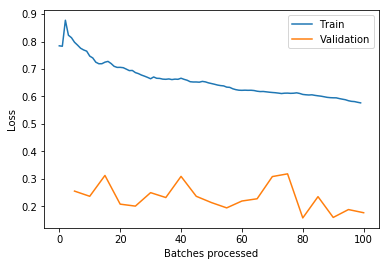

In [39]:
learn.recorder.plot_losses()

A final round of training

In [40]:
learn.fit(20, 1e-3)

epoch,train_loss,valid_loss,time
0,0.520447,0.164861,00:01
1,0.504365,0.150697,00:01
2,0.503227,0.159944,00:01
3,0.502797,0.163466,00:01
4,0.510268,0.149820,00:01
5,0.519390,0.153828,00:01
6,0.513723,0.164787,00:01
7,0.506492,0.152648,00:01
8,0.508879,0.164765,00:01
9,0.507821,0.162553,00:01


We can see that the loss is stagnating here, and we may be reaching the limits of our super simple model. Below we'll examine results.

# Results

Use the test-time augmentation to make ensemble-averaged predictions (e.g., using affine transformations specified in `tfms`).

In [63]:
Z_pred, Z_true = learn.TTA()

# store results, along with objID, in new DataFrame
results = pd.DataFrame({'Z_true': Z_true.squeeze(), 'Z_pred': Z_pred.squeeze()})
results['objID'] = np.array([os.path.basename(fn)[:-4] for fn in data.valid_ds.items], dtype=np.int64)
results.set_index('objID', drop=True, inplace=True)

results.sample(3)

,Z_true,Z_pred
objID,,
1237664673788854376,8.755769,8.705401
1237654604788203674,9.006755,8.802835
1237654605322191093,9.071786,8.806539


In [64]:
# our validation set RMSE
root_mean_squared_error(Z_pred, Z_true)

tensor(0.1571)

We'll define some simple helper functions for visualizing our predictions.

In [78]:
OffsetImage(image2np(open_image(f'{PATH}/train/1237664673788854376.jpg').data))

In [0]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def offset_image(objID, zoom=0.1):
    return OffsetImage(image2np(open_image(f'{PATH}/train/{objID}.jpg').data), zoom=zoom)

def plot_results(results, show_images=True):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.scatter('Z_true', 'Z_pred', data=results, c='black')

    if show_images:
        artists = []
        for objID, [Z_true, Z_pred] in results.iterrows():
            ab = AnnotationBbox(offset_image(objID, zoom=0.4), (Z_true, Z_pred), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
            
    # plot 1:1 line
    plt.plot([7, 10], [7, 10], c='C3', ls='--', lw='10')

    ax.set_xlim(8.2, 9.2)
    ax.set_ylim(8.2, 9.2)
    ax.set_xlabel('True metallicity')
    ax.set_ylabel('Predicted metallicity')

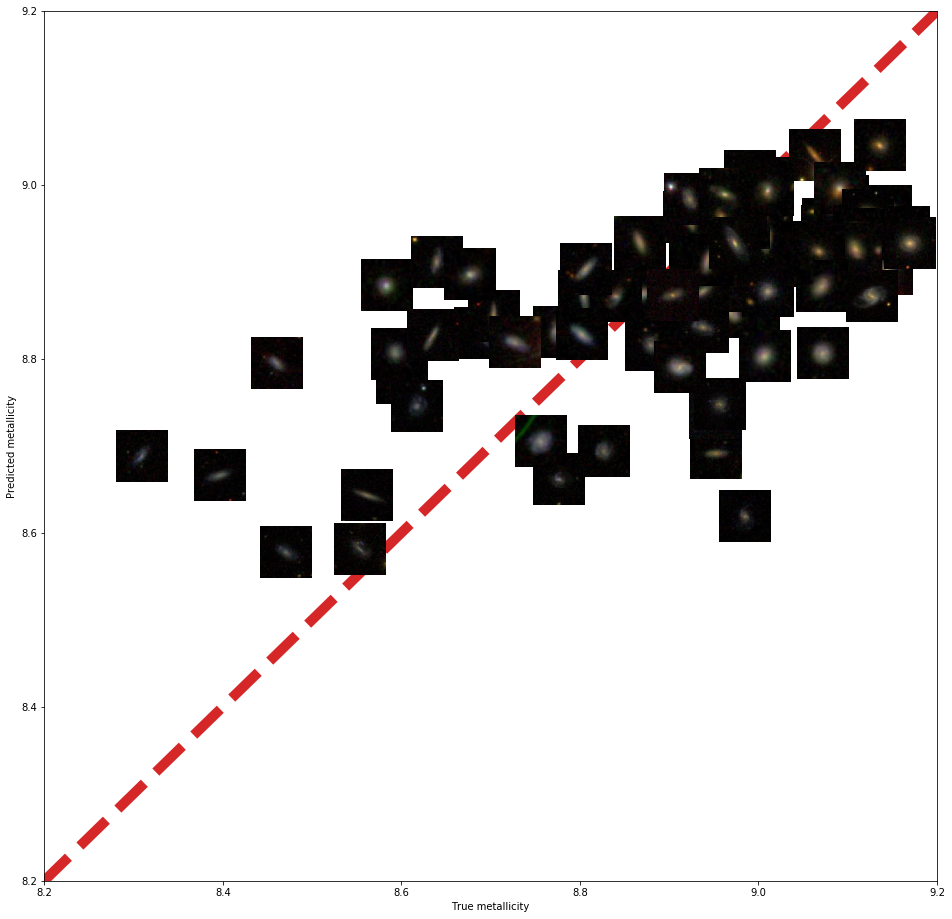

In [101]:
plot_results(results)

# Train simple convnet in fewer number of steps

Here we will make use of the 1-cycle learning schedule, which doesn't require us to manually anneal the learning rate.

In [0]:
# reset the convnet
learn = cnn_learner(data, base_arch=SimpleCNN, pretrained=False, loss_func=root_mean_squared_error)

In [108]:
# fit for 30 cycles right off the bat
max_lr = 0.1
learn.fit_one_cycle(30, max_lr)

epoch,train_loss,valid_loss,time
0,8.773746,7.844404,00:01
1,8.292515,6.622245,00:01
2,6.903181,1.425118,00:01
3,5.961073,4.028018,00:01
4,5.212612,1.324813,00:01
5,4.583358,0.875522,00:01
6,4.134293,0.629028,00:01
7,3.791321,1.474831,00:01
8,3.479818,1.345665,00:01
9,3.179016,0.645704,00:01


This could benefit from additional training, but we'l stop here.

In [109]:
Z_pred, Z_true = learn.TTA()
results = pd.DataFrame({'Z_true': Z_true.squeeze(), 'Z_pred': Z_pred.squeeze()})
results['objID'] = np.array([os.path.basename(fn)[:-4] for fn in data.valid_ds.items], dtype=np.int64)
results.set_index('objID', drop=True, inplace=True)

In [111]:
root_mean_squared_error(Z_pred, Z_true)

tensor(0.1409)

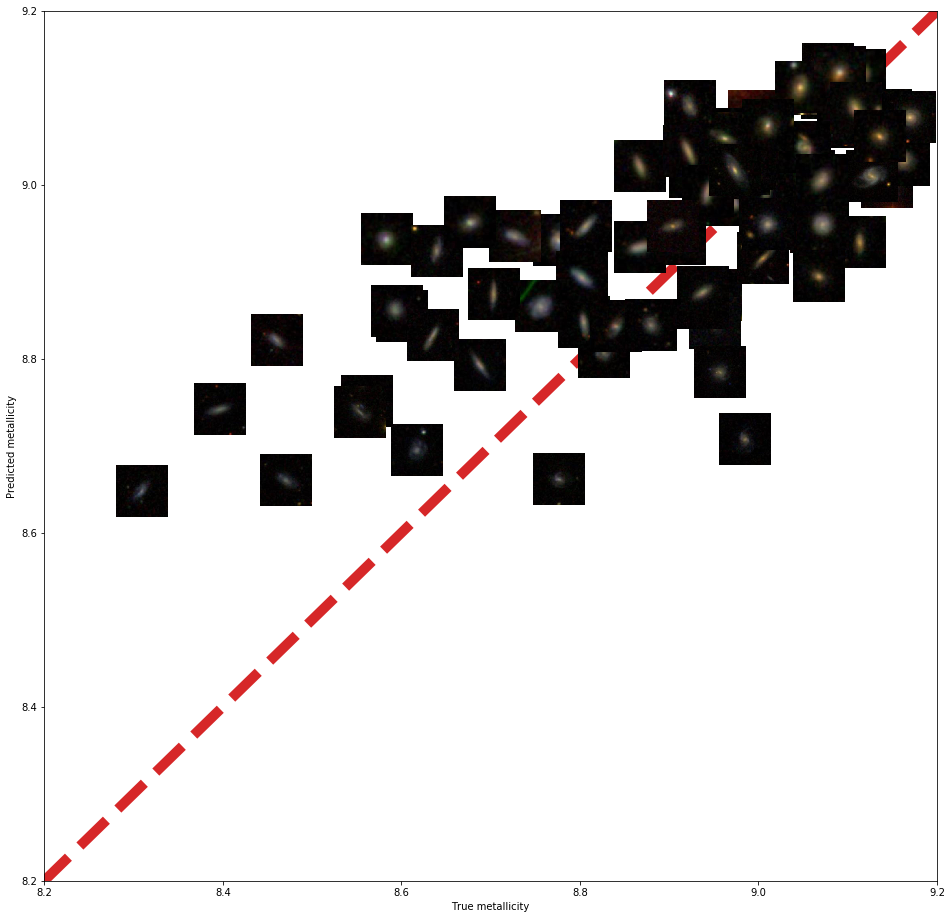

In [110]:
plot_results(results)

# Use pretrained `resnet34`

Now we are going to use a much more sophisticated model, a 34-layer convnet. Morever, we'll be using the model with pretrained weights (trained on ImageNet), and will also be making use of discriminative learning rates at different layers of the deep network.

(If this sounds like overkill, it's because it is. 320 data points should be incredibly overfit using this million-parameter model.)

In [0]:
learn = cnn_learner(data, base_arch=models.resnet18, pretrained=True, loss_func=root_mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


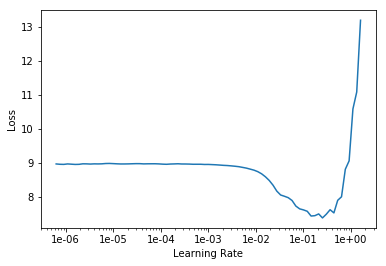

In [129]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [140]:
learn.fit_one_cycle(100, slice(3e-4, 3e-2))

epoch,train_loss,valid_loss,time
0,8.964321,8.570707,00:01
1,8.808202,8.521845,00:01
2,8.701218,8.304064,00:01
3,8.564909,7.944231,00:01
4,8.411118,7.455719,00:01
5,8.162663,6.693299,00:01
6,7.822877,5.452251,00:01
7,7.311130,3.403878,00:01
8,6.564137,0.997026,00:01
9,5.957762,3.064183,00:01


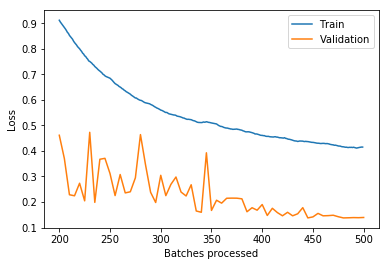

In [142]:
learn.recorder.plot_losses(skip_start=200)

We can train for much longer since this is a deeper model with many more parameters. But in this case, we're rather limited by the size of our training data. And yet, 320 training examples appears to be enough for the convnet to learn something!

In [143]:
Z_pred, Z_true = learn.TTA()
results = pd.DataFrame({'Z_true': Z_true.squeeze(), 'Z_pred': Z_pred.squeeze()})
results['objID'] = np.array([os.path.basename(fn)[:-4] for fn in data.valid_ds.items], dtype=np.int64)
results.set_index('objID', drop=True, inplace=True)

display(root_mean_squared_error(Z_true, Z_pred))

tensor(0.1289)

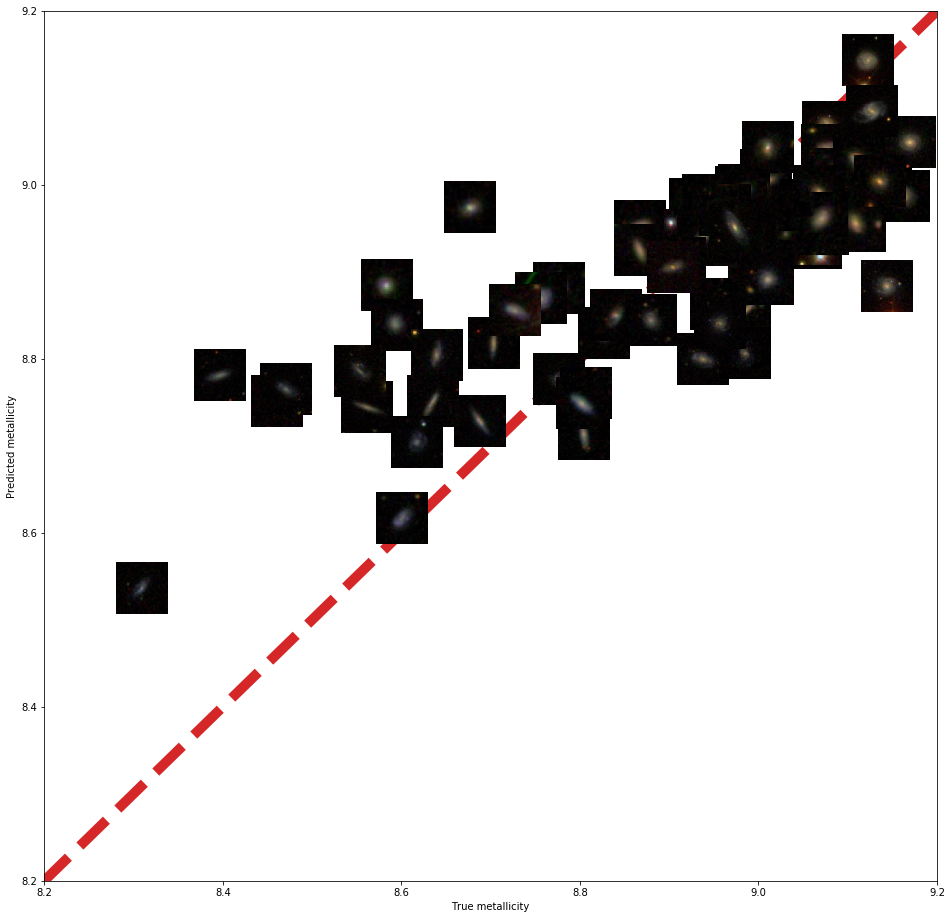

In [144]:
plot_results(results)